# Leapfrog integration

The leapfrog integrator is one of the most simple symplectic integrator with second order accuracy.

- First, the positions are advanced for half a time step assuming the velocities fixed (kick).
- Then, the velocities are advanced for one time step keeping the positions fixed (drift).
- Finally, the positions are advanced for half a time step assuming the velocities fixed (kick)

With $x_n$ and $u_n$ the position and velocity for the x-coordinates ($y_n$ and $v_n$ the position and velocity for the y-coordinates)
\begin{equation}
\begin{split}
x_{n+1/2} &= x_n + \frac{\Delta t}{2} u_n & \quad \textrm{(kick)}\\
u_{n+1}   &= u_n  - \frac{\mu}{(x_{n+1/2}^2+y_{n+1/2}^2)^{3/2}} x_{n+1/2} \Delta t & \quad \textrm{(drift)}\\
x_{n+1}   &= x_{n+1/2} + \frac{\Delta t}{2} u_{n+1} & \quad \textrm{(kick)}
\end{split}
\end{equation}





In [1]:
import numpy as np
import matplotlib.pyplot as plt

Let us define the function of the exact solution (which we know !)

Here $\omega = n = \mu/a^3$, where $a$ is the semi-major axis

In [2]:
# Exact solution for the x coordinate of the position
def position_x(a, t, omega):
    return a * np.cos(omega * t)
def position_y(a, t, omega):
    return a * np.sin(omega * t)
# Exact solution for the x coordinate of the velocity
def velocity_x(a, t, omega):
    return - a * omega * np.sin(omega * t)
def velocity_y(a, t, omega):
    return a * omega * np.cos(omega * t)

Let us define the 4 derivatives

In [3]:
# Velocities for the 2 components
def dx_dt(x, y, u, v):
    return u
def dy_dt(x, y, u, v):
    return v

# Accelerations for the 2 components
def du_dt(x, y, u, v, mu):
    omega_squared = mu/np.power(x*x + y*y, 3./2.)
    return - omega_squared * x
def dv_dt(x, y, u, v, mu):
    omega_squared = mu/np.power(x*x + y*y, 3./2.)
    return - omega_squared * y

Now let us define an evolver function, which will perform the Leapfrog integration. We want to keep in memory the solution x(t), v(t) and the time t to later plot the result and compare it to the exact solution. 

In [4]:
def evolve_Leapfrog(x0, y0, u0, v0,  mu, dt, N_steps):
    xl = np.zeros((N_steps + 1))
    ul = np.zeros((N_steps + 1))
    yl = np.zeros((N_steps + 1))
    vl = np.zeros((N_steps + 1))
    tl = np.zeros((N_steps + 1))

    xl[0], yl[0] = x0, y0
    ul[0], vl[0], tl[0] = u0, v0, 0

    print("now is time to work")
    for i in range(N_steps):
        xl_tmp = xl[i] + (dt/2)*ul[i] # kick x
        yl_tmp = yl[i] + (dt/2)*vl[i] # kick y
        
        ul[i+1] = ul[i] + (du_dt(x=xl_tmp, y=yl_tmp, u=ul[i], v=vl[i], mu=mu)*dt) # drift x
        vl[i+1] = vl[i] + (dv_dt(x=xl_tmp, y=yl_tmp, u=ul[i], v=vl[i], mu=mu)*dt) # drift x
        
        xl[i+1] = xl_tmp + (dt/2)*ul[i+1] # kick x
        yl[i+1] = yl_tmp + (dt/2)*vl[i+1] # kick y
        
        tl[i+1] = tl[i] + dt
    return tl, xl, yl, ul, vl

We here also put Euler's integration for comparison.

In [5]:
def evolve_Euler(x0, y0, u0, v0,  mu, dt, N_steps):
    xe = np.zeros((N_steps + 1))
    ue = np.zeros((N_steps + 1))
    ye = np.zeros((N_steps + 1))
    ve = np.zeros((N_steps + 1))
    te = np.zeros((N_steps + 1))

    xe[0], ye[0] = x0, y0
    ue[0], ve[0], te[0] = u0, v0, 0

    for i in range(N_steps):
        xe[i+1] = xe[i] + dt * dx_dt(xe[i], ye[i], ue[i], ve[i])
        ye[i+1] = ye[i] + dt * dy_dt(xe[i], ye[i], ue[i], ve[i])
        ue[i+1] = ue[i] + dt * du_dt(xe[i], ye[i], ue[i], ve[i], mu)
        ve[i+1] = ve[i] + dt * dv_dt(xe[i], ye[i], ue[i], ve[i], mu)
        te[i+1] = te[i] + dt
    return te, xe, ye, ue, ve

Now let's define the initial conditions.
And compute both an array with the exact solution and 2 arrays with the integration results.

In [6]:
Time_max = 10

# Initial conditions for the integration
mu = 1.0
x0, y0 = 1.0, 0.0
u0, v0 = 0.0, 1.0
dt = 0.01

omega = np.sqrt(mu/np.power(x0*x0+y0*y0, 3./2.))
N_steps = int(Time_max/float(dt))

# Computation of the exact solution
time = np.arange(Time_max*10)/10.
exact_solution_x  = [position_x(x0, tt, omega) for tt in time]
exact_solution_y  = [position_y(x0, tt, omega) for tt in time]
exact_solution_u  = [velocity_x(x0, tt, omega) for tt in time]
exact_solution_v  = [velocity_y(x0, tt, omega) for tt in time]
    
# Computation of the Leapfrog's integration
tl, xl, yl, ul, vl = evolve_Leapfrog(x0, y0, u0, v0,  mu, dt, N_steps)
# Computation of the Euler's integration
te, xe, ye, ue, ve = evolve_Euler(x0, y0, u0, v0,  mu, dt, N_steps)

now is time to work


Now let's plot both the exact solution and the integration result

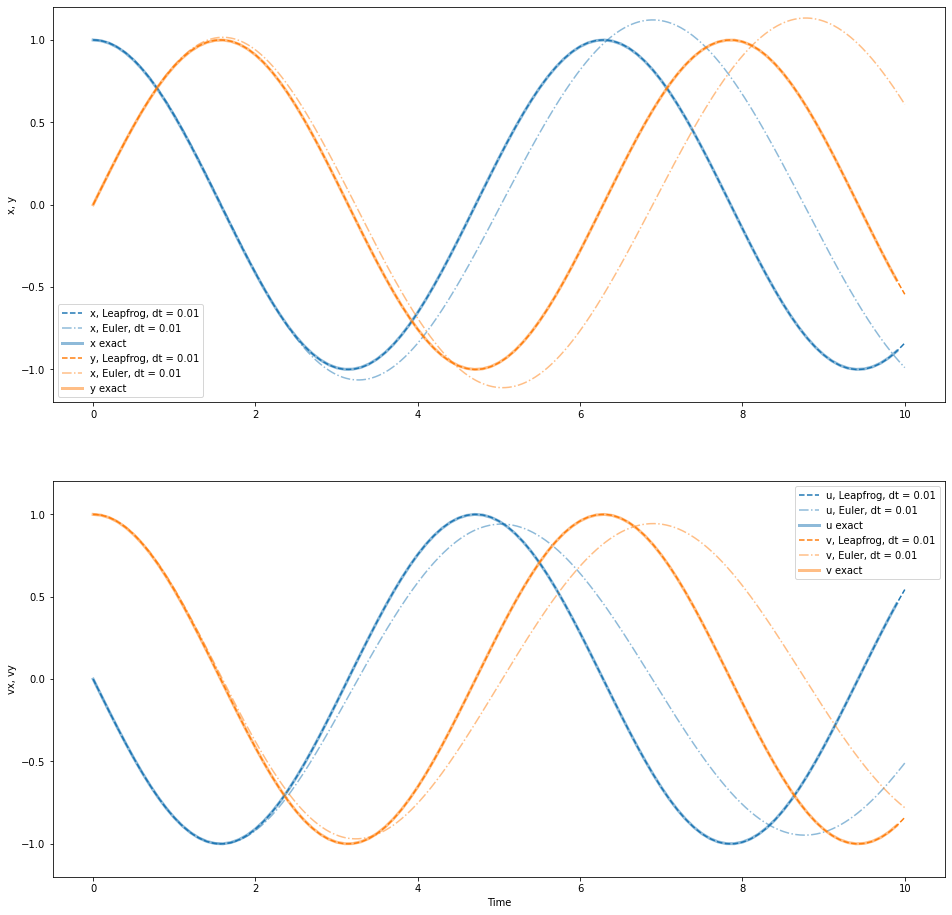

In [11]:
fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(2,1,1)

line, = ax.plot(tl, xl, '--', label="x, Leapfrog, dt = %.2f" %dt)
ax.plot(te, xe, '-.', c=line.get_color(), label="x, Euler, dt = %.2f" %dt, alpha=0.5)
ax.plot(time, exact_solution_x, '-', c=line.get_color(), label="x exact", lw=3, alpha=0.5)

line, = ax.plot(tl, yl, '--', label="y, Leapfrog, dt = %.2f" %dt)
ax.plot(te, ye, '-.', c=line.get_color(), label="x, Euler, dt = %.2f" %dt, alpha=0.5)
ax.plot(time, exact_solution_y, '-', c=line.get_color(), label="y exact", lw=3, alpha=0.5)

ax.set_ylim([-1.2,1.2])
ax.set_ylabel("x, y")
ax.legend(loc=0, prop={'size':10})

ax = fig.add_subplot(2,1,2, sharex=ax)

line, = ax.plot(tl, ul, '--', label="u, Leapfrog, dt = %.2f" %dt)
ax.plot(te, ue, '-.', c=line.get_color(), label="u, Euler, dt = %.2f" %dt, alpha=0.5)
ax.plot(time, exact_solution_u, '-', c=line.get_color(), label="u exact", lw=3, alpha=0.5)

line, = ax.plot(tl, vl, '--', label="v, Leapfrog, dt = %.2f" %dt)
ax.plot(te, ve, '-.', c=line.get_color(), label="v, Euler, dt = %.2f" %dt, alpha=0.5)
ax.plot(time, exact_solution_v, '-', c=line.get_color(), label="v exact", lw=3, alpha=0.5)

ax.set_ylim([-1.2,1.2])
ax.set_ylabel("vx, vy")
ax.set_xlabel("Time")
ax.legend(loc=0, prop={'size':10})

It looks good!

Let's evolve it a bit more

In [12]:
Time_max = 100
N_steps = int(Time_max/float(dt))

# Computation of the Leapfrog's integration
tl, xl, yl, ul, vl = evolve_Leapfrog(x0, y0, u0, v0,  mu, dt, N_steps)

# Computation of the exact solution
time = np.arange(Time_max*10)/10.
exact_solution_x  = [position_x(x0, tt, omega) for tt in time]
exact_solution_y  = [position_y(x0, tt, omega) for tt in time]
exact_solution_u  = [velocity_x(x0, tt, omega) for tt in time]
exact_solution_v  = [velocity_y(x0, tt, omega) for tt in time]

now is time to work


And plot

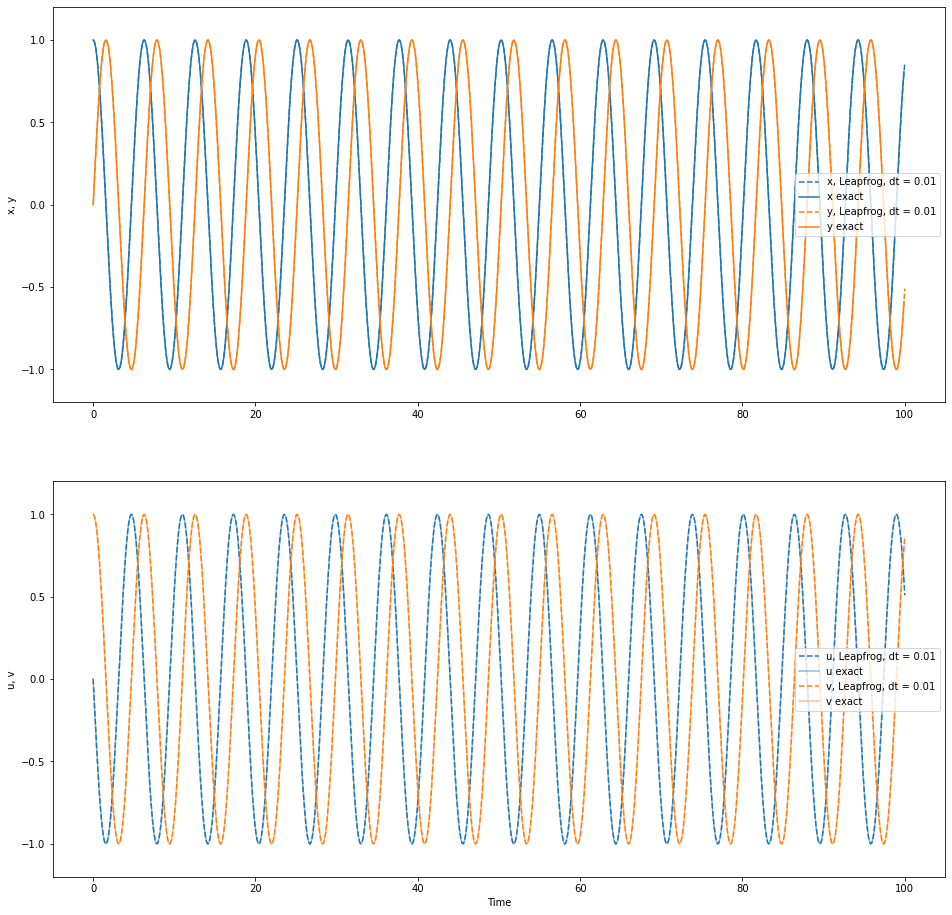

In [13]:
fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(2,1,1)

line, = ax.plot(tl, xl, '--', label="x, Leapfrog, dt = %.2f" %dt)
ax.plot(time, exact_solution_x, '-', c=line.get_color(), label="x exact")
line, = ax.plot(tl, yl, '--', label="y, Leapfrog, dt = %.2f" %dt)
ax.plot(time, exact_solution_y, '-', c=line.get_color(), label="y exact")

ax.set_ylim([-1.2,1.2])
ax.set_ylabel("x, y")
ax.legend(loc=0, prop={'size':10})

ax = fig.add_subplot(2,1,2, sharex=ax)

line, = ax.plot(tl, ul, '--', label="u, Leapfrog, dt = %.2f" %dt)
ax.plot(time, exact_solution_u, '-', c=line.get_color(), label="u exact", alpha=0.5)
line, = ax.plot(tl, vl, '--', label="v, Leapfrog, dt = %.2f" %dt)
ax.plot(time, exact_solution_v, '-', c=line.get_color(), label="v exact", alpha=0.5)

ax.set_ylim([-1.2,1.2])
ax.set_ylabel("u, v")
ax.set_xlabel("Time")
ax.legend(loc=0, prop={'size':10})

This still looks very good!

Let's integrate it even more 

In [14]:
Time_max = 1000
N_steps = int(Time_max/float(dt))

# Computation of the Leapfrog's integration
tl, xl, yl, ul, vl = evolve_Leapfrog(x0, y0,u0, v0,  mu, dt, N_steps)

# Computation of the exact solution
time = np.arange(Time_max*10)/10.
exact_solution_x  = [position_x(x0, tt, omega) for tt in time]
exact_solution_y  = [position_y(x0, tt, omega) for tt in time]
exact_solution_u  = [velocity_x(x0, tt, omega) for tt in time]
exact_solution_v  = [velocity_y(x0, tt, omega) for tt in time]

now is time to work


And let us plot only the end of the evolution

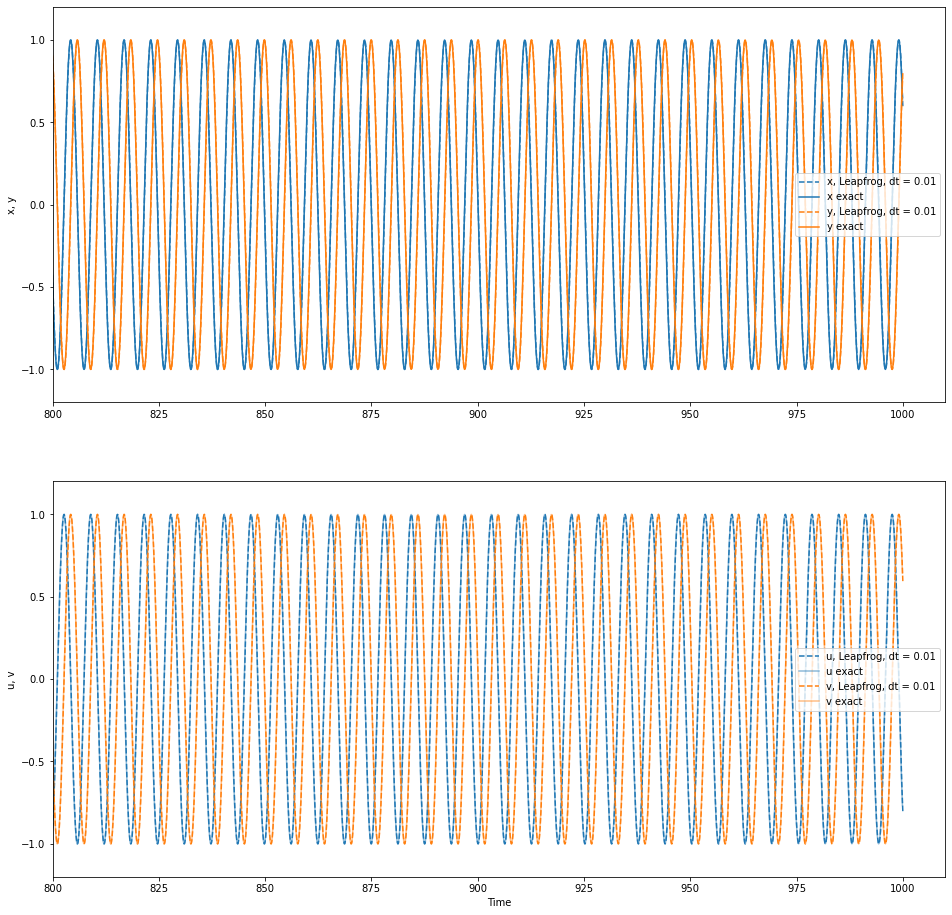

In [16]:
fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(2,1,1)

line, = ax.plot(tl, xl, '--', label="x, Leapfrog, dt = %.2f" %dt)
ax.plot(time, exact_solution_x, '-', c=line.get_color(), label="x exact")
line, = ax.plot(tl, yl, '--', label="y, Leapfrog, dt = %.2f" %dt)
ax.plot(time, exact_solution_y, '-', c=line.get_color(), label="y exact")

ax.set_ylim([-1.2,1.2])
ax.set_ylabel("x, y")
ax.legend(loc=0, prop={'size':10})

ax = fig.add_subplot(2,1,2, sharex=ax)

line, = ax.plot(tl, ul, '--', label="u, Leapfrog, dt = %.2f" %dt)
ax.plot(time, exact_solution_u, '-', c=line.get_color(), label="u exact", alpha=0.5)
line, = ax.plot(tl, vl, '--', label="v, Leapfrog, dt = %.2f" %dt)
ax.plot(time, exact_solution_v, '-', c=line.get_color(), label="v exact", alpha=0.5)

ax.set_xlim([800, 1010])
ax.set_ylim([-1.2,1.2])
ax.set_ylabel("u, v")
ax.set_xlabel("Time")
ax.legend(loc=0, prop={'size':10})

### Let's investigate the effect of the timestep

now is time to work
now is time to work
now is time to work


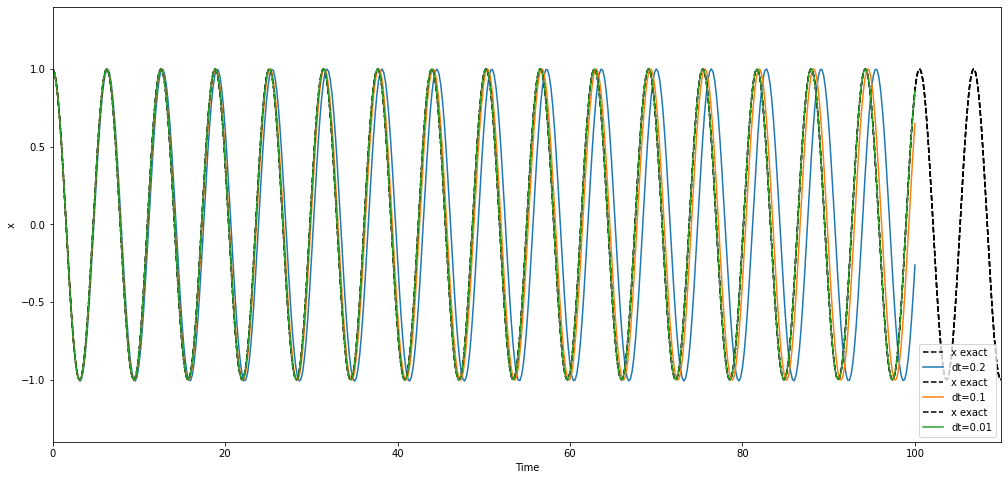

In [18]:
Time_max = 100

fig = plt.figure(figsize=(17, 8))
ax = fig.add_subplot(1,1,1)

for dt in [0.2, 0.1, 0.01]:
    N_steps = int(Time_max/float(dt))
    # Computation of the Leapfrog's integration
    tl, xl, yl, ul, vl = evolve_Leapfrog(x0, y0,u0, v0,  mu, dt, N_steps)
    ax.plot(time, exact_solution_x, '--', c='k', label="x exact")
    ax.plot(tl, xl, label="dt={}".format(dt))

ax.set_xlim([0,110])
ax.set_ylim([-1.4,1.4])
ax.set_ylabel("x")
ax.set_xlabel("Time")
ax.legend(loc=0, prop={'size':10})

The amplitude of the oscillations is constant but increasing the timestep leads to a shift of the frequency

## Phase space

To visualize this a bit differently, let us plot the phase space: $u = f(x)$ and $v = f(y)$

now is time to work


(-1.5, 1.5)

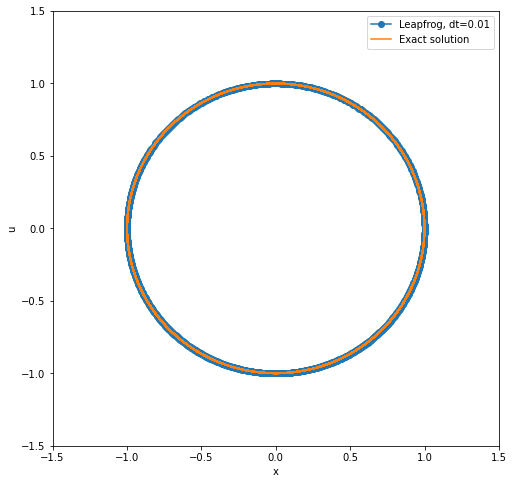

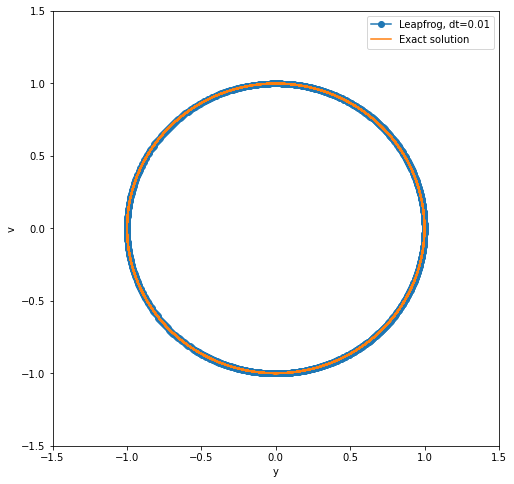

In [20]:
Time_max = 10
dt = 0.01
N_steps = int(Time_max/float(dt))
tl, xl, yl, ul, vl = evolve_Leapfrog(x0, y0,u0, v0,  mu, dt, N_steps)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1,1,1)

ax.plot(xl, ul, '-o', label="Leapfrog, dt={}".format(dt))
ax.plot(exact_solution_x, exact_solution_u, label="Exact solution") 
ax.set_ylabel("u")
ax.set_xlabel("x")
ax.legend(loc=0, prop={'size':10})
ax.set_ylim([-1.5,1.5])
ax.set_xlim([-1.5,1.5])

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1,1,1)

ax.plot(yl, vl, '-o', label="Leapfrog, dt={}".format(dt))
ax.plot(exact_solution_y, exact_solution_v, label="Exact solution") 
ax.set_ylabel("v")
ax.set_xlabel("y")
ax.legend(loc=0, prop={'size':10})
ax.set_ylim([-1.5,1.5])
ax.set_xlim([-1.5,1.5])


## Let us compute the error

We will compute the error on the x-component of the position compared it to the corresponding analytical solution.

In [21]:
Time_max = 1000
dt = 0.1
N_steps = int(Time_max/float(dt))

# Computation of the Leapfrog's and Euler's integrations
tl, xl, yl, ul, vl = evolve_Leapfrog(x0, y0,u0, v0,  mu, dt, N_steps)
te, xe, ye, ue, ve = evolve_Euler(x0, y0, u0, v0,  mu, dt, N_steps)

# Computation of the exact solution
exact_solution_x  = [position_x(x0, tt, omega) for tt in tl]
exact_solution_y  = [position_y(x0, tt, omega) for tt in tl]
exact_solution_u  = [velocity_x(x0, tt, omega) for tt in tl]
exact_solution_v  = [velocity_y(x0, tt, omega) for tt in tl]

now is time to work


now is time to work: plot the error for the x position for Leapfrog and Euler


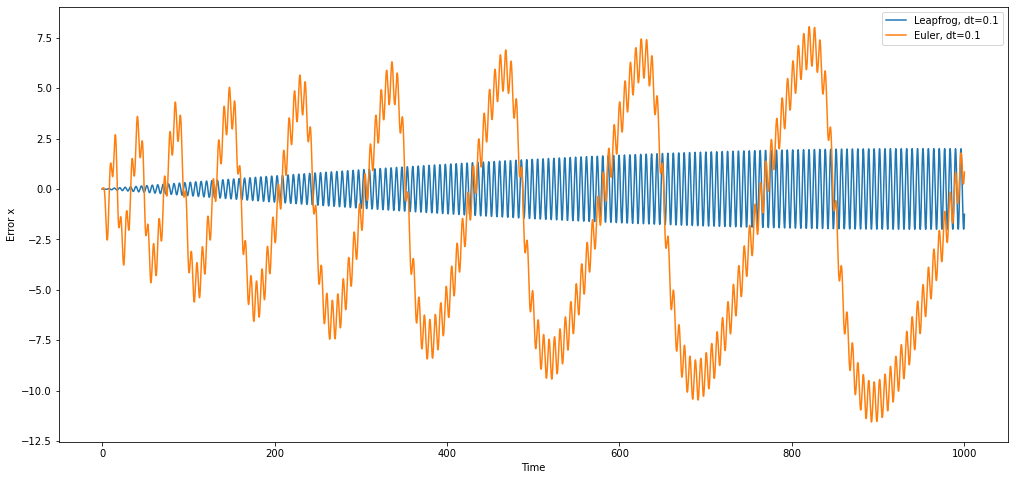

In [23]:
fig = plt.figure(figsize=(17, 8))
ax = fig.add_subplot(1,1,1)

print("now is time to work: plot the error for the x position for Leapfrog and Euler")
ax.plot(tl, xl-exact_solution_x, label="Leapfrog, dt={}".format(dt))
ax.plot(tl, xe-exact_solution_x, label="Euler, dt={}".format(dt))

#ax.set_xlim([0,110])
#ax.set_ylim([-1.4,1.4])
ax.set_ylabel("Error x")
ax.set_xlabel("Time")
ax.legend(loc=0, prop={'size':10})

The error seems to be increasing as well, but on longer timescales.

What happens if we integrate it on a longer time.

In [27]:
print("now is time to work: play with Time_max")

Time_max = 10000
dt = 0.1
N_steps = int(Time_max/float(dt))

# Computation of the Leapfrog's and Euler's integrations
tl, xl, yl, ul, vl = evolve_Leapfrog(x0, y0,u0, v0,  mu, dt, N_steps)
te, xe, ye, ue, ve = evolve_Euler(x0, y0, u0, v0,  mu, dt, N_steps)

# Computation of the exact solution
exact_solution_x  = [position_x(x0, tt, omega) for tt in tl]
exact_solution_y  = [position_y(x0, tt, omega) for tt in tl]
exact_solution_u  = [velocity_x(x0, tt, omega) for tt in tl]
exact_solution_v  = [velocity_y(x0, tt, omega) for tt in tl]

now is time to work: play with Time_max
now is time to work


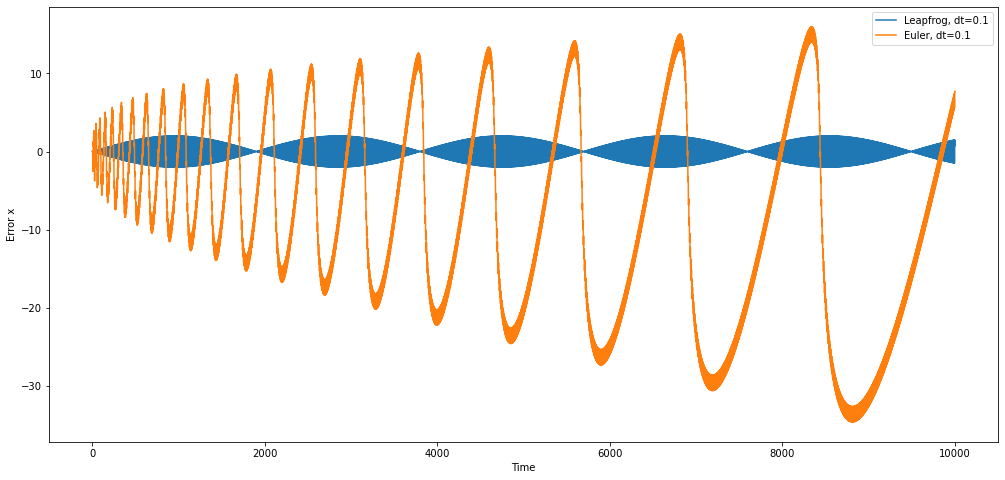

In [28]:
fig = plt.figure(figsize=(17, 8))
ax = fig.add_subplot(1,1,1)

ax.plot(tl, xl-exact_solution_x, label="Leapfrog, dt={}".format(dt))
ax.plot(tl, xe-exact_solution_x, label="Euler, dt={}".format(dt))

#ax.set_xlim([0,110])
#ax.set_ylim([-1.4,1.4])
ax.set_ylabel("Error x")
ax.set_xlabel("Time")
ax.legend(loc=0, prop={'size':10})

## Energy of the system: is it conserved?



The energy of the system is given by
\begin{equation}
E = E_{\rm grav} + E_{\rm kin} = - \frac{\mu}{r} + \frac{1}{2} v^2 = -\frac{C}{r}
\end{equation}
where $r = \sqrt{x^2+y^2}$ and $v^2 = v_x^2 + v_y^2$.

We will compute $\Delta E = E(t) - E(t=0)$. If there is conservation of the energy, this should be zero.  

now is time to work
now is time to work
now is time to work


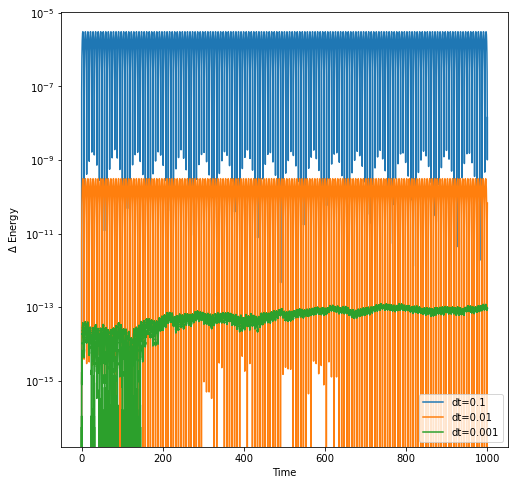

In [30]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1,1,1)

Time_max = 1000

for dt in [0.1, 0.01, 0.001]:
    N_steps = int(Time_max/float(dt))
    # Computation of the Euler's integration
    tl, xl, yl, ul, vl = evolve_Leapfrog(x0, y0, u0, v0,  mu, dt, N_steps)
    
    # Compute the energy compared to the Energy at time 0
    delta_energy = np.zeros((N_steps+1))
    energy_0 = -mu/np.sqrt(xl[0]**2 + yl[0]**2) + 0.5 * (ul[0]**2 + vl[0]**2)
    for i in range(N_steps+1):
        delta_energy[i] = -mu/np.sqrt(xl[i]**2 + yl[i]**2) + 0.5 * (ul[i]**2 + vl[i]**2) - energy_0

    ax.plot(tl, delta_energy, label="dt={}".format(dt))
    ax.set_ylabel("$\Delta$ Energy")
    ax.set_xlabel("Time")
    ax.set_yscale('log')
    #ax.set_xscale('log')
    ax.legend(loc=0, prop={'size':10})

Energy conservation is pretty good and improves with smaller time steps.

## Angular momentum: is it conserved?

Another quantity which is supposed to be conserved is the total angular momentum.

The angular momentum in the heliocentric frame is given by
\begin{equation}
\mathbf{h} = \frac{m_0 m_1}{m_0 + m_1}\mathbf{r} \times \mathbf{v}
\end{equation}

For our example, the angular momentum (per unit mass) is given by
\begin{equation}
\begin{split}
\mathbf{h} &= \mathbf{r} \times \mathbf{v}\\
h_z &= x v_y - y v_x
\end{split}
\end{equation}

Let us see if this quantity is conserved. To do that let us compute $\Delta h_z = h_z(t) - h_z(t=0)$.

now is time to work
now is time to work
now is time to work


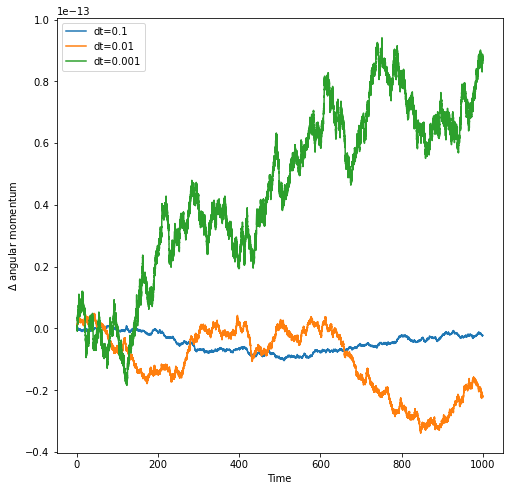

In [31]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1,1,1)

Time_max = 1000

for dt in [0.1, 0.01, 0.001]:
    N_steps = int(Time_max/float(dt))
    # Computation of the Leapfrog's integration
    tl, xl, yl, ul, vl = evolve_Leapfrog(x0, y0, u0, v0,  mu, dt, N_steps)
    
    # Compute the energy compared to the Energy at time 0
    delta_angular_momentum = np.zeros((N_steps+1))
    angular_momentum_0 = xl[0]*vl[0] - yl[0]*ul[0]
    for i in range(N_steps+1):
        delta_angular_momentum[i] = (xl[i]*vl[i] - yl[i]*ul[i]) - angular_momentum_0

    ax.plot(tl, delta_angular_momentum, label="dt={}".format(dt))
    ax.set_ylabel("$\Delta$ angular momentum")
    ax.set_xlabel("Time")
    #ax.set_yscale('log')
    #ax.set_xscale('log')
    ax.legend(loc=0, prop={'size':10})

The angular momentum is well conserved but is worst for smaller time steps...

There are more efficient symplectic integrators than leapfrog.